In [11]:
# %%
"""
05_vision_ocr.ipynb – OCR Google Vision dla zdjęć z katalogu data/staging/test_scenes.

Uwaga:
– wymagane poprawne uwierzytelnienie GCP (zmienna środowiskowa GOOGLE_APPLICATION_CREDENTIALS
  lub inna metoda zgodna z dokumentacją).
"""

from pathlib import Path
from datetime import datetime, timezone
from contextlib import nullcontext
import io
import time
import json

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from google.cloud import vision

In [12]:
# %%
"""
Ścieżki projektu i podstawowe ustawienia.
"""

PROJECT_ROOT = Path(".").resolve()
DIR_DATA = PROJECT_ROOT / "data"
DIR_STAGING = DIR_DATA / "test_scenes"

DIR_OUT = PROJECT_ROOT / "outputs"
DIR_OUT.mkdir(parents=True, exist_ok=True)

DIR_OCR = DIR_OUT / "ocr"
DIR_OCR.mkdir(parents=True, exist_ok=True)

CSV_PATH = DIR_OCR / "vision_ocr_words.csv"

LOGS_DIR = PROJECT_ROOT / "logs"
LOGS_DIR.mkdir(parents=True, exist_ok=True)
RUNLOG_PATH = LOGS_DIR / "runlog.jsonl"

print("Wejście (obrazy):", DIR_STAGING)
print("Wyjście (CSV):   ", CSV_PATH)

Wejście (obrazy): /Users/olga/MetaLogic/data/test_scenes
Wyjście (CSV):    /Users/olga/MetaLogic/outputs/ocr/vision_ocr_words.csv


In [13]:
# %%
"""
Ustawienie ścieżki do klucza Google Vision na lokalnym Macu.
"""

import os

VISION_KEY_PATH = PROJECT_ROOT / "secrets" / "vision-key.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(VISION_KEY_PATH)

print("GOOGLE_APPLICATION_CREDENTIALS =", os.environ["GOOGLE_APPLICATION_CREDENTIALS"])

GOOGLE_APPLICATION_CREDENTIALS = /Users/olga/MetaLogic/secrets/vision-key.json


In [14]:
# %%
"""
Klient Google Vision.
"""

def make_vision_client() -> vision.ImageAnnotatorClient:
    """
    Tworzy klienta Google Vision.

    Wymaga:
    – skonfigurowanych poświadczeń GCP,
    – poprawnego projektu w środowisku.
    """
    client = vision.ImageAnnotatorClient()
    return client


vision_client = make_vision_client()
vision_client

In [15]:
# %%
"""
Funkcje pomocnicze: wczytywanie obrazów, listowanie plików, dzielenie na kafelki.
"""

def list_images(root: Path):
    """
    Zwraca listę ścieżek do obrazów (jpg/jpeg/png/tif/tiff) w katalogu root (rekurencyjnie).

    root – katalog startowy (Path)
    """
    exts = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
    return [p for p in root.rglob("*") if p.suffix.lower() in exts]


def load_image(path: Path) -> Image.Image:
    """
    Wczytuje obraz jako obiekt PIL.Image w trybie RGB.

    path – ścieżka do pliku graficznego
    """
    img = Image.open(path)
    return img.convert("RGB")


def make_tiles(img: Image.Image, n_cols: int = 2, n_rows: int = 2):
    """
    Dzieli obraz na prostą siatkę kafelków (n_cols × n_rows).

    img    – obiekt PIL.Image
    n_cols – liczba kolumn kafelków
    n_rows – liczba wierszy kafelków

    Zwraca listę słowników:
    {
        "tile_id": int,
        "bbox": (x1, y1, x2, y2) – współrzędne w obrazie pełnym
    }
    """
    w, h = img.size
    tile_w = w // n_cols
    tile_h = h // n_rows

    tiles = []
    tile_id = 0
    for row in range(n_rows):
        for col in range(n_cols):
            x1 = col * tile_w
            y1 = row * tile_h
            # ostatnia kolumna/wiersz – do końca obrazu
            x2 = w if col == n_cols - 1 else x1 + tile_w
            y2 = h if row == n_rows - 1 else y1 + tile_h
            tiles.append(
                {
                    "tile_id": tile_id,
                    "bbox": (x1, y1, x2, y2),
                }
            )
            tile_id += 1
    return tiles

In [16]:
# %%
"""
OCR pojedynczego kafelka obrazu z Google Vision (poziom słów).
"""

def bbox_vertices_to_xyxy(vertices, offset_x: int = 0, offset_y: int = 0):
    """
    Zamienia bounding_box.vertices z Vision na (x1, y1, x2, y2)
    z uwzględnieniem przesunięcia kafelka.

    vertices – lista 4 punktów (x, y) z Google Vision
    offset_x – przesunięcie kafelka względem obrazu pełnego (oś X)
    offset_y – przesunięcie kafelka względem obrazu pełnego (oś Y)
    """
    xs = [v.x + offset_x for v in vertices]
    ys = [v.y + offset_y for v in vertices]
    x1, x2 = min(xs), max(xs)
    y1, y2 = min(ys), max(ys)
    return float(x1), float(y1), float(x2), float(y2)


def ocr_tile_words(
    img_full: Image.Image,
    tile_bbox,
    client: vision.ImageAnnotatorClient,
    lang=("pl",),
):
    """
    Wykonuje OCR dokumentowy (document_text_detection) na pojedynczym kafelku obrazu.

    img_full – pełny obraz PIL.Image
    tile_bbox – (x1, y1, x2, y2) współrzędne kafelka w obrazie pełnym
    client   – klient Google Vision
    lang     – krotka kodów językowych, np. ("pl",)
    """
    x1, y1, x2, y2 = map(int, tile_bbox)
    crop = img_full.crop((x1, y1, x2, y2))

    buf = io.BytesIO()
    crop.save(buf, format="PNG")
    image = vision.Image(content=buf.getvalue())

    response = client.document_text_detection(
        image=image,
        image_context=vision.ImageContext(language_hints=list(lang)),
    )

    if response.error.message:
        raise RuntimeError(f"Vision OCR error: {response.error.message}")

    records = []

    annotation = response.full_text_annotation
    for page in annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    word_text = "".join([s.text for s in word.symbols])
                    x1w, y1w, x2w, y2w = bbox_vertices_to_xyxy(
                        word.bounding_box.vertices,
                        offset_x=x1,
                        offset_y=y1,
                    )
                    records.append(
                        {
                            "text": word_text,
                            "level": "word",
                            "x1": x1w,
                            "y1": y1w,
                            "x2": x2w,
                            "y2": y2w,
                        }
                    )

    return records

In [17]:
# %%
"""
OCR całego obrazu (tiling 2×2) – zbiera słowa ze wszystkich kafelków.
"""

def ocr_image_tiled_words(
    path: Path,
    client: vision.ImageAnnotatorClient,
    n_cols: int = 2,
    n_rows: int = 2,
    lang=("pl",),
):
    """
    Wykonuje OCR dla całego obrazu poprzez podział na kafelki.

    path   – ścieżka do pliku obrazu
    client – klient Google Vision
    n_cols – liczba kolumn kafelków
    n_rows – liczba wierszy kafelków
    lang   – krotka kodów językowych, np. ("pl",)

    Zwraca listę rekordów:
    {
        "file_path": ...,   ścieżka relatywna do PROJECT_ROOT
        "tile_id":   ...,   numer kafelka
        "text":      ...,   rozpoznany tekst (słowo)
        "level":     "word",
        "x1", "y1", "x2", "y2" – bounding box w koordynatach obrazu pełnego
    }
    """
    img = load_image(path)
    tiles = make_tiles(img, n_cols=n_cols, n_rows=n_rows)

    records_all = []
    for tile in tiles:
        tile_id = tile["tile_id"]
        bbox = tile["bbox"]
        try:
            recs = ocr_tile_words(
                img_full=img,
                tile_bbox=bbox,
                client=client,
                lang=lang,
            )
        except RuntimeError as e:
            print(f"OCR error for {path.name}, tile {tile_id}: {e}")
            continue

        for r in recs:
            r["file_path"] = str(path.relative_to(PROJECT_ROOT))
            r["tile_id"] = tile_id
        records_all.extend(recs)

    return records_all

In [ ]:
# %%
"""
Główna pętla: OCR losowej próbki obrazów z katalogu wejściowego.

MAX_IMAGES – ile obrazów skanujemy (losowa, ale powtarzalna próbka).
"""

import random
import time

IN_DIR = DIR_STAGING
N_COLS = 3
N_ROWS = 3
LANG_HINTS = ("pl",)
MAX_IMAGES = 20  # zmień w razie potrzeby

all_imgs = list_images(IN_DIR)
print("Łączna liczba obrazów w katalogu:", len(all_imgs))

# losowa, ale powtarzalna próbka
random.seed(42)
random.shuffle(all_imgs)
if MAX_IMAGES is not None:
    image_paths = all_imgs[:MAX_IMAGES]
else:
    image_paths = all_imgs

print("Liczba obrazów do OCR:", len(image_paths))
for p in image_paths[:10]:
    print(" •", p.name)
if len(image_paths) > 10:
    print(" ...")

all_records = []
t0 = time.time()

for i, path in enumerate(image_paths, start=1):
    print(f"[{i}/{len(image_paths)}] OCR:", path.name)
    recs = ocr_image_tiled_words(
        path=path,
        client=vision_client,
        n_cols=N_COLS,
        n_rows=N_ROWS,
        lang=LANG_HINTS,
    )
    all_records.extend(recs)

dt = time.time() - t0
print(f"Łączny czas OCR: {dt:.1f} s, liczba słów: {len(all_records)}")

df_ocr = pd.DataFrame(all_records)
df_ocr.head()

Łączna liczba obrazów w katalogu: 271
Liczba obrazów do OCR: 20
 • JMi_0716.tif
 • JMi_2112.tif
 • JMi_2389.tif
 • JMi_6191.tif
 • JMi_0344.tif
 • JMi_5667.tif
 • turzanskiw_569.tif
 • JMi_3423.tif
 • turzanskiw_931.tiff
 • JMi_5888.tif
 ...
[1/20] OCR: JMi_0716.tif
[2/20] OCR: JMi_2112.tif
[3/20] OCR: JMi_2389.tif
[4/20] OCR: JMi_6191.tif
[5/20] OCR: JMi_0344.tif
[6/20] OCR: JMi_5667.tif
[7/20] OCR: turzanskiw_569.tif
[8/20] OCR: JMi_3423.tif
[9/20] OCR: turzanskiw_931.tiff
[10/20] OCR: JMi_5888.tif
[11/20] OCR: JMi_5855.tif
[12/20] OCR: JMi_6182.tif
[13/20] OCR: JMi_4083.jpg
[14/20] OCR: turzanskiw_760.jpg
[15/20] OCR: JMi_0349.tif
[16/20] OCR: turzanskiw_574.tif
[17/20] OCR: turzanskiw_925k.tiff
[18/20] OCR: Jmi_0343.tif
[19/20] OCR: JMi_5856.tif
[20/20] OCR: JMi_2834.tif
Łączny czas OCR: 160.6 s, liczba słów: 163


,text,level,x1,y1,x2,y2,file_path,tile_id
0,MEDH,word,116.0,801.0,162.0,844.0,data/test_scenes/JMi_0716.tif,0
1,ZILE,word,145.0,822.0,184.0,860.0,data/test_scenes/JMi_0716.tif,0
2,MARKSON,word,168.0,839.0,223.0,883.0,data/test_scenes/JMi_0716.tif,0
3,DOCOOO,word,492.0,1653.0,533.0,1659.0,data/test_scenes/JMi_0716.tif,3
4,6,word,1106.0,1310.0,1117.0,1326.0,data/test_scenes/JMi_0716.tif,4


In [28]:
# %%
"""
Zapis wyników OCR do CSV oraz logu runlog.jsonl.
"""

timestamp = datetime.now(timezone.utc).isoformat()
df_ocr["timestamp"] = timestamp

df_ocr.to_csv(CSV_PATH, index=False)
print("Zapisano wyniki OCR do:", CSV_PATH)

runlog_entry = {
    "timestamp": timestamp,
    "step": "vision_ocr_words_tiled",
    "n_images": int(len(image_paths)),
    "n_words": int(len(df_ocr)),
    "csv_path": str(CSV_PATH),
    "in_dir": str(IN_DIR),
    "n_cols": N_COLS,
    "n_rows": N_ROWS,
    "lang_hints": list(LANG_HINTS),
}

with RUNLOG_PATH.open("a", encoding="utf-8") as f:
    f.write(json.dumps(runlog_entry, ensure_ascii=False) + "\n")

print("Dopisano wpis do:", RUNLOG_PATH)

Zapisano wyniki OCR do: /Users/olga/MetaLogic/outputs/ocr/vision_ocr_words.csv
Dopisano wpis do: /Users/olga/MetaLogic/logs/runlog.jsonl


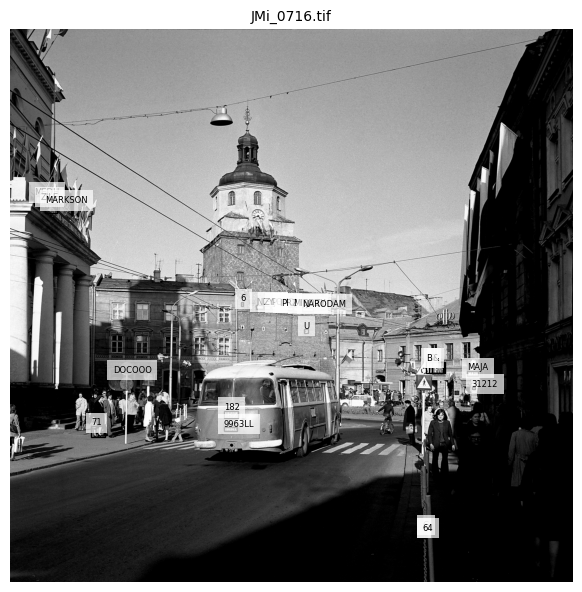

In [27]:
# %%
"""
Podgląd: nałożenie bounding boxów OCR na wybrany obraz.
"""

def plot_ocr_boxes_for_image(
    path: Path,
    df: pd.DataFrame,
    project_root: Path,
    max_words: int = 50,
):
    """
    Rysuje obraz z nałożonymi bounding boxami i fragmentami tekstu.

    path        – ścieżka do obrazu
    df          – DataFrame (subset dla danego pliku)
    project_root – katalog bazowy repozytorium
    max_words   – maksymalna liczba słów do pokazania (aby uniknąć chaosu)
    """
    img = load_image(path)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img)
    ax.axis("off")

    subset = df.head(max_words)

    for _, row in subset.iterrows():
        x1, y1, x2, y2 = row["x1"], row["y1"], row["x2"], row["y2"]
        text = row["text"]

        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)
        ax.text(
            x1,
            max(y1 - 5, 0),
            text,
            fontsize=6,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )

    ax.set_title(path.name, fontsize=10)
    plt.tight_layout()
    plt.show()


if not df_ocr.empty:
    sample_file = df_ocr["file_path"].iloc[0]
    img_path = PROJECT_ROOT / sample_file
    df_sample = df_ocr[df_ocr["file_path"] == sample_file]
    plot_ocr_boxes_for_image(img_path, df_sample, PROJECT_ROOT)
else:
    print("Brak danych OCR do wizualizacji.")

In [29]:
# %%
"""
Podgląd: nałożenie bounding boxów OCR na wybrany obraz.

Można sterować:
- max_words   – ile słów pokazać (żeby nie było chaosu),
- figsize     – rozmiar miniatury (szerokość, wysokość w calach).
"""

def plot_ocr_boxes_for_image(
    path: Path,
    df: pd.DataFrame,
    project_root: Path,
    max_words: int = 50,
    figsize=(4, 4),
):
    """
    Rysuje obraz z nałożonymi bounding boxami i fragmentami tekstu.

    path        – ścieżka do obrazu
    df          – DataFrame (subset dla danego pliku)
    project_root – katalog bazowy repozytorium
    max_words   – maksymalna liczba słów do pokazania
    figsize     – rozmiar wykresu (tuple: szerokość, wysokość)
    """
    img = load_image(path)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.axis("off")

    subset = df.head(max_words)

    for _, row in subset.iterrows():
        x1, y1, x2, y2 = row["x1"], row["y1"], row["x2"], row["y2"]
        text = row["text"]

        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)
        ax.text(
            x1,
            max(y1 - 5, 0),
            text,
            fontsize=6,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )

    ax.set_title(path.name, fontsize=8)
    plt.tight_layout()
    plt.show()

Liczba obrazów w podglądzie: 16

=== OCR preview: JMi_0716.tif ===


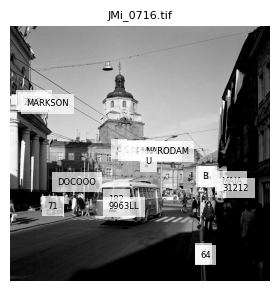


=== OCR preview: JMi_2112.tif ===


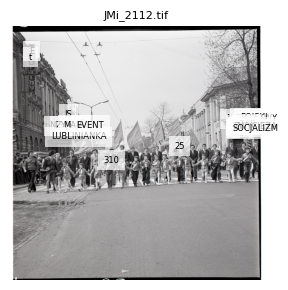


=== OCR preview: JMi_2389.tif ===


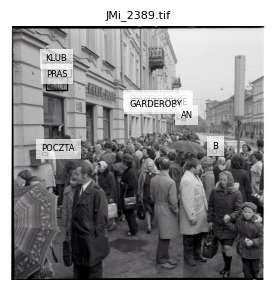


=== OCR preview: JMi_6191.tif ===


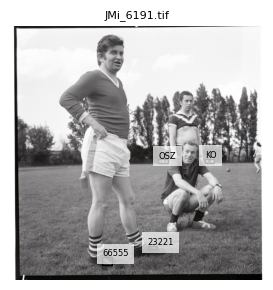


=== OCR preview: JMi_0344.tif ===


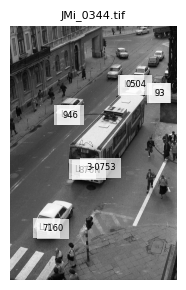


=== OCR preview: JMi_5667.tif ===


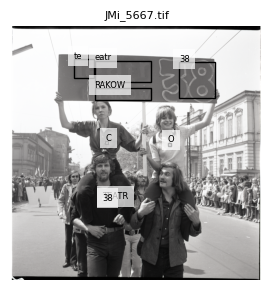


=== OCR preview: turzanskiw_569.tif ===


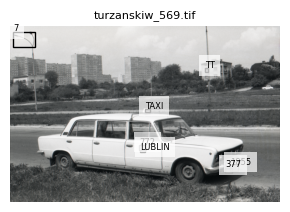


=== OCR preview: JMi_3423.tif ===


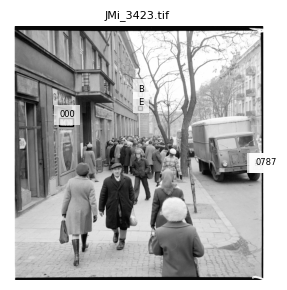


=== OCR preview: turzanskiw_931.tiff ===


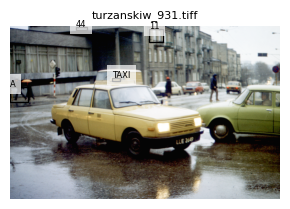


=== OCR preview: JMi_5855.tif ===


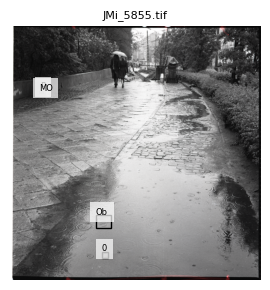


=== OCR preview: turzanskiw_760.jpg ===


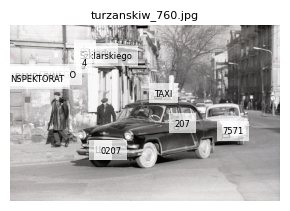


=== OCR preview: JMi_0349.tif ===


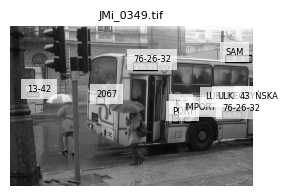


=== OCR preview: turzanskiw_574.tif ===


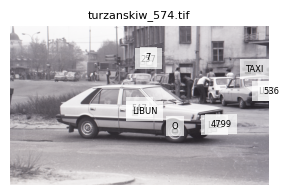


=== OCR preview: turzanskiw_925k.tiff ===


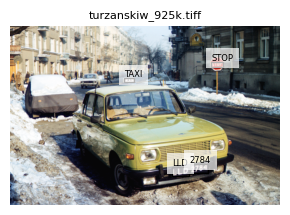


=== OCR preview: Jmi_0343.tif ===


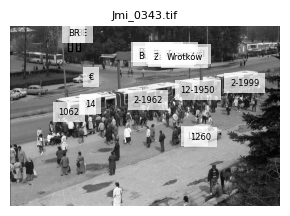


=== OCR preview: JMi_5856.tif ===


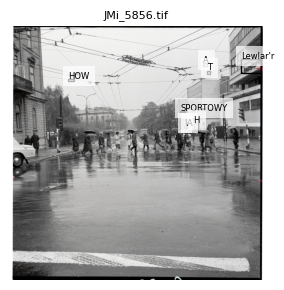

In [30]:
# %%
"""
Podgląd wszystkich obrazów z bieżącej próbki OCR
jako miniatury z nałożonymi bounding boxami OCR.
"""

N_PREVIEW_IMAGES = 20       # ile obrazów pokazać (powinno odpowiadać MAX_IMAGES z OCR)
MAX_WORDS_PER_IMAGE = 40    # limit słów na obraz, żeby nie przeładować podglądu

if df_ocr.empty:
    print("df_ocr jest pusty – najpierw uruchom komórkę z pętlą OCR.")
else:
    unique_files = df_ocr["file_path"].unique()[:N_PREVIEW_IMAGES]
    print("Liczba obrazów w podglądzie:", len(unique_files))

    for rel_path in unique_files:
        img_path = PROJECT_ROOT / rel_path
        df_sample = df_ocr[df_ocr["file_path"] == rel_path]
        print("\n=== OCR preview:", img_path.name, "===")
        plot_ocr_boxes_for_image(
            img_path,
            df_sample,
            PROJECT_ROOT,
            max_words=MAX_WORDS_PER_IMAGE,
            figsize=(3, 3),   # thumbnail
        )